In [44]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import xrft
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from scipy.interpolate import PchipInterpolator as pchip
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [ ]:
ys10, dy10 = (272,5)
ys5, dy5 = (31,5)
dt = 6e2
df = 144
ts = int(360*86400*ys10/dt+df)
te = int(360*86400*(ys10+dy10)/dt+df)
print(ts,te)
dsFe = open_mdsdataset(op.join(ddir,'zerores_10km_Fe'), grid_dir=op.join(ddir,'10km_grid'),
                      iters=range(ts,te,df),
                      prefix=['FeTtave'], delta_t=dt
                      )
dsB = open_mdsdataset(op.join(ddir,'zerores_10km_PZ'), grid_dir=op.join(ddir,'10km_grid'),
                     iters=range(ts,te,df),
                     prefix=['P1Ptave','P2Ptave'], delta_t=dt
                     )
dsB

14100624 14359824


/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [ ]:
Fe = dsFe.TRAC03
P1 = dsB.TRAC22
P2 = dsB.TRAC23

In [ ]:
P1Fe = (P1*Fe).compute()
P2Fe = (P2*Fe).compute()

In [ ]:
P1Fe.sel(YC=slice(11e5,14e5))[0,0].plot(vmax=1e-6, vmin=1e-8, norm=colors.LogNorm())

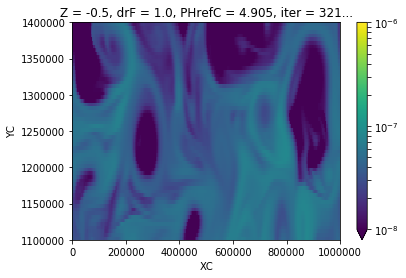

In [29]:
P2Fe.sel(YC=slice(11e5,14e5))[0,0].plot(vmax=1e-6, vmin=1e-8, norm=colors.LogNorm())

In [ ]:
with ProgressBar():
    p1kfek = (xrft.dft(P1[::15].sel(YC=slice(10e5,15e5)), dim=['XC'])
             * np.conj(xrft.dft(Fe[::15].sel(YC=slice(10e5,15e5)), dim=['XC']))
             ).real.compute()
    p2kfek = (xrft.dft(P2[::15].sel(YC=slice(10e5,15e5)), dim=['XC'])
             * np.conj(xrft.dft(Fe[::15].sel(YC=slice(10e5,15e5)), dim=['XC']))
             ).real.compute()
p1kfek

In [ ]:
seas = np.tile(np.repeat(range(4),6),dy10)
p1kfek.coords['seas'] = ('time',seas)
p2kfek.coords['seas'] = ('time',seas)
p1kfek_seas = p1kfek.groupby('seas').mean('time').compute()
p2kfek_seas = p2kfek.groupby('seas').mean('time').compute()

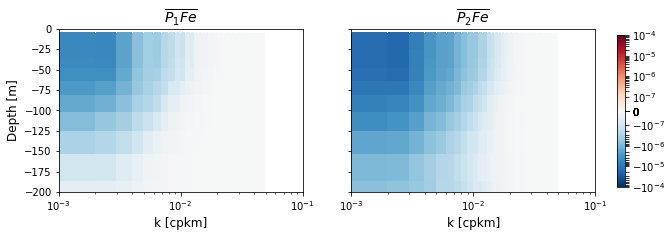

In [55]:
nx = 51
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
im = ax1.pcolormesh(p1kfek_seas.freq_XC[nx:]*1e3, p1kfek_seas.Z, 
                    p1kfek_seas[2,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
                    cmap='RdBu_r', vmax=1e-4, vmin=-1e-4,
                    norm=colors.SymLogNorm(1e-7, vmax=1e-4, vmin=-1e-4))
ax2.pcolormesh(p2kfek_seas.freq_XC[nx:]*1e3, p2kfek_seas.Z, 
               p2kfek_seas[2,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
               cmap='RdBu_r', vmax=1e-4, vmin=-1e-4,
               norm=colors.SymLogNorm(1e-7, vmax=1e-4, vmin=-1e-4))
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_yticklabels([])
ax1.set_ylim([-2e2,0])
ax2.set_ylim([-2e2,0])
ax1.set_xlim([1e-3,1e-1])
ax2.set_xlim([1e-3,1e-1])
ax1.set_title(r"$\overline{P_1Fe}$", fontsize=14)
ax2.set_title(r"$\overline{P_2Fe}$", fontsize=14)
ax1.set_xlabel(r"k [cpkm]", fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"k [cpkm]", fontsize=12)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, format=ticker.LogFormatterMathtext())
# cbar.set_label(r"JAS$-$JFM [mmol Fe m$^{-3}$ s$^{-1}$)]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/BiomassFe_JAS_10km.pdf'))

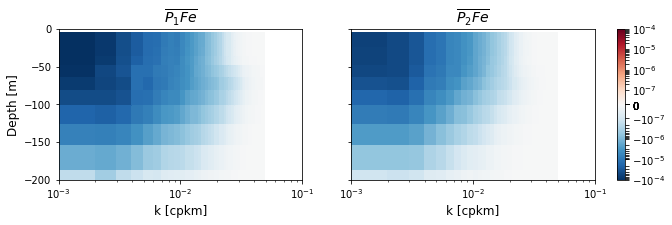

In [56]:
nx = 51
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
im = ax1.pcolormesh(p1kfek_seas.freq_XC[nx:]*1e3, p1kfek_seas.Z, 
                    p1kfek_seas[3,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
                    cmap='RdBu_r', vmax=1e-4, vmin=-1e-4,
                    norm=colors.SymLogNorm(1e-7, vmax=1e-4, vmin=-1e-4))
ax2.pcolormesh(p2kfek_seas.freq_XC[nx:]*1e3, p2kfek_seas.Z, 
               p2kfek_seas[3,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
               cmap='RdBu_r', vmax=1e-4, vmin=-1e-4,
               norm=colors.SymLogNorm(1e-7, vmax=1e-4, vmin=-1e-4))
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_yticklabels([])
ax1.set_ylim([-2e2,0])
ax2.set_ylim([-2e2,0])
ax1.set_xlim([1e-3,1e-1])
ax2.set_xlim([1e-3,1e-1])
ax1.set_title(r"$\overline{P_1Fe}$", fontsize=14)
ax2.set_title(r"$\overline{P_2Fe}$", fontsize=14)
ax1.set_xlabel(r"k [cpkm]", fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"k [cpkm]", fontsize=12)
fig.subplots_adjust(right=0.87)
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, format=ticker.LogFormatterMathtext())
# cbar.set_label(r"JAS$-$JFM [mmol Fe m$^{-3}$ s$^{-1}$)]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/BiomassFe_OND_10km.pdf'))

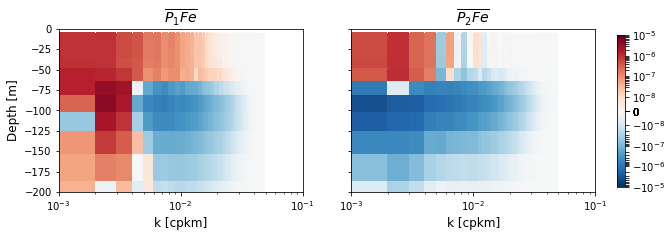

In [58]:
nx = 51
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
im = ax1.pcolormesh(p1kfek_seas.freq_XC[nx:]*1e3, p1kfek_seas.Z, 
                    p1kfek_seas[0,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
                    cmap='RdBu_r', vmax=1e-5, vmin=-1e-5,
                    norm=colors.SymLogNorm(1e-8, vmax=1e-5, vmin=-1e-5))
ax2.pcolormesh(p2kfek_seas.freq_XC[nx:]*1e3, p2kfek_seas.Z, 
               p2kfek_seas[0,:,:,nx:].sel(YC=slice(11e5,14e5)).mean(['YC']),
               cmap='RdBu_r', vmax=1e-5, vmin=-1e-5,
               norm=colors.SymLogNorm(1e-8, vmax=1e-5, vmin=-1e-5))
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_yticklabels([])
ax1.set_ylim([-2e2,0])
ax2.set_ylim([-2e2,0])
ax1.set_xlim([1e-3,1e-1])
ax2.set_xlim([1e-3,1e-1])
ax1.set_title(r"$\overline{P_1Fe}$", fontsize=14)
ax2.set_title(r"$\overline{P_2Fe}$", fontsize=14)
ax1.set_xlabel(r"k [cpkm]", fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"k [cpkm]", fontsize=12)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, format=ticker.LogFormatterMathtext())
# cbar.set_label(r"JAS$-$JFM [mmol Fe m$^{-3}$ s$^{-1}$)]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/BiomassFe_JFM_10km.pdf'))